# データセットなど

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch
import numpy as np
from sklearn.decomposition import PCA
from torch import nn
import types
import matplotlib.pyplot as plt
from torch.func import jacrev, vmap
from sklearn.feature_extraction.text import CountVectorizer
from re import M
from math import cos
from torch.utils.data import DataLoader
from scipy.stats import linregress
import random

class MyDataset():
    dataset_dict = {
        'cifar10': torchvision.datasets.CIFAR10,
        'cifar10_12': torchvision.datasets.CIFAR10,
        'cifar10_34': torchvision.datasets.CIFAR10,
        'cifar10_56': torchvision.datasets.CIFAR10,
        'cifar10_78': torchvision.datasets.CIFAR10,
    }

    def __init__(self, dataset_name, data_dir=None, binarize=False, binarize_images=False, format='NCHW', pca_dims=None, standardization=False):
        self.name = dataset_name
        self.pca_dims = pca_dims
        self.binarize_images = binarize_images
        self.standardization = standardization

        def standardize(X):
            mean = np.mean(X, axis=0, keepdims=True)
            std = np.std(X, axis=0, keepdims=True)
            std[std == 0] = 1
            return (X - mean) / std

        def format_data(dataset):
            X, y = dataset.data, dataset.targets
            X = X.reshape(len(X), -1)

            if self.name == 'cifar10_12':
                mask = np.isin(y, [0, 1])
                X, y = X[mask], np.array(y)[mask]
                y = (y == 1).astype(int)

            elif self.name == 'cifar10_34':
                mask = np.isin(y, [2, 3])
                X, y = X[mask], np.array(y)[mask]
                y = (y == 3).astype(int)

            elif self.name == 'cifar10_56':
                mask = np.isin(y, [4, 5])
                X, y = X[mask], np.array(y)[mask]
                y = (y == 5).astype(int)

            elif self.name == 'cifar10_78':
                mask = np.isin(y, [6, 7])
                X, y = X[mask], np.array(y)[mask]
                y = (y == 7).astype(int)

            if format == 'NHWC':
                X = X.reshape(len(X), 32, 32, 3)

            if self.standardization:
                X = standardize(X)

            if self.binarize_images:
                X = np.where(X < 0.5, -1, 1)

            y = F.one_hot(torch.Tensor(y).long()).numpy()

            if self.pca_dims:
                pca = PCA(n_components=self.pca_dims)
                X = pca.fit_transform(X)

            return X.astype(np.float32), y.astype(np.float32)

        transform = transforms.Compose([transforms.ToTensor()])
        raw_train = self.dataset_dict[self.name](root=data_dir, train=True, download=True, transform=transform)
        raw_test = self.dataset_dict[self.name](root=data_dir, train=False, download=True, transform=transform)

        self.train_X, self.train_y = format_data(raw_train)
        self.test_X, self.test_y = format_data(raw_test)

    def get_dataset(self, n, get="train", rng=None, class_eq=False):
        n = int(n)
        assert n > 0, "データセットのサイズは正の整数"
        assert get in ["train", "test"], "'get'は'train'または'test'を指定"

        full_X, full_y = (self.train_X, self.train_y) if get == "train" else (self.test_X, self.test_y)

        if rng is None:
            rng = np.random.default_rng()

        if class_eq:
            n_classes = full_y.shape[1]
            class_indices = [np.where(full_y[:, i] == 1)[0] for i in range(n_classes)]

            samples_per_class = n // n_classes
            remainder = n % n_classes
            indices = []

            for i, class_idx in enumerate(class_indices):
                n_samples = samples_per_class + (1 if i < remainder else 0)
                selected_indices = rng.choice(class_idx, size=n_samples, replace=False)
                indices.extend(selected_indices)

            rng.shuffle(indices)
        else:
            indices = rng.permutation(len(full_X))[:n]

        X, y = full_X[indices].copy(), full_y[indices].copy()

        assert len(X) == n, "サンプリングされたデータのサイズが期待と異なる"

        return X, y


#############################################################################################

class CustomDataLoader:
    def __init__(self, X, y, batch_size, shuffle, **kwargs):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataset = torch.utils.data.TensorDataset(self.X, self.y)

    def __iter__(self):
        num_batches = len(self.X) // self.batch_size
        indices = torch.randperm(len(self.X)) if self.shuffle else torch.arange(len(self.X))

        for i in range(num_batches):
            batch_indices = indices[i * self.batch_size:(i + 1) * self.batch_size]
            X_batch = self.X[batch_indices]
            y_batch = self.y[batch_indices]
            yield X_batch, y_batch

class BalancedDataLoader(CustomDataLoader):
    def __init__(self, X, y, batch_size, shuffle=True, **kwargs):
        super().__init__(X, y, batch_size, shuffle, **kwargs)
        self.class_indices = {i: torch.where(torch.argmax(y, dim=1) == i)[0] for i in range(y.shape[1])}
        self.num_classes = len(self.class_indices)

    def __iter__(self):
        if self.batch_size == 1:
            indices = torch.randperm(len(self.X)) if self.shuffle else torch.arange(len(self.X))
            for i in range(len(self.X)):
                yield self.X[indices[i:i + 1]], self.y[indices[i:i + 1]]
        else:
            class_batch_size = max(1, self.batch_size // self.num_classes)
            min_class_size = min(len(indices) for indices in self.class_indices.values())
            total_batches = max(1, min_class_size // class_batch_size)

            for _ in range(total_batches):
                batch_indices = []
                for class_idx, indices in self.class_indices.items():
                    if self.shuffle:
                        selected_indices = indices[torch.randperm(len(indices))[:class_batch_size]]
                    else:
                        selected_indices = indices[:class_batch_size]
                    batch_indices.append(selected_indices)

                selected_batch_indices = torch.cat(batch_indices)
                X_batch = self.X[selected_batch_indices]
                y_batch = self.y[selected_batch_indices]
                yield X_batch, y_batch

def train_error(model, train_loader):
    model.train()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output, _, _, _, _, _, _, _, _, _, _, _ = model(data)
            train_loss += F.mse_loss(output, target, reduction='sum').item() / target.shape[1]
            pred = output.argmax(dim=1)
            correct += (pred == target.argmax(dim=1)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return train_loss, accuracy

def test_error(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output, _, _, _, _, _, _, _, _, _, _, _ = model(data)
            d_out = output.shape[1]
            test_loss += F.mse_loss(output, target, reduction='sum').item() / d_out
            pred = output.argmax(dim=1)
            correct += (pred == target.argmax(dim=1)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy


def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 実験（10時間以上要する可能性あり）


In [2]:
# Dynamic Parametrization
class MLP_1(nn.Module):
    def __init__(self, d_in, d_out, n1, n2, n3, n4, n5, r_value):
        super().__init__()

        # g1, g2, g3, g4, g5, g6 の計算
        n_min = min(n1, n2, n3, n4, n5)
        activity1 = n_min ** r_value
        activity2 = n_min ** r_value
        activity3 = n_min ** r_value
        activity4 = n_min ** r_value
        activity5 = n_min ** r_value
        activity6 = n_min ** r_value

        self.activity1 = activity1
        self.activity2 = activity2
        self.activity3 = activity3
        self.activity4 = activity4
        self.activity5 = activity5
        self.activity6 = activity6
        self.n1, self.n2, self.n3, self.n4, self.n5 = n1, n2, n3, n4, n5

        self.g1 = activity1 / torch.sqrt(torch.tensor(d_in, dtype=torch.float32))
        self.g2 = activity2 / torch.sqrt(torch.tensor(n1, dtype=torch.float32))
        self.g3 = activity3 / torch.sqrt(torch.tensor(n2, dtype=torch.float32))
        self.g4 = activity4 / torch.sqrt(torch.tensor(n3, dtype=torch.float32))
        self.g5 = activity5 / torch.sqrt(torch.tensor(n4, dtype=torch.float32))
        self.g6 = 1 / torch.sqrt(torch.tensor(n5, dtype=torch.float32))

        # 各層の重み行列
        self.fc1 = nn.Linear(d_in, n1, bias=False)
        self.fc2 = nn.Linear(n1, n2, bias=False)
        self.fc3 = nn.Linear(n2, n3, bias=False)
        self.fc4 = nn.Linear(n3, n4, bias=False)
        self.fc5 = nn.Linear(n4, n5, bias=False)
        self.fc6 = nn.Linear(n5, d_out, bias=False)

        self.gamma = torch.sqrt(torch.tensor(2.0))

        # 重みを個別に初期化
        nn.init.normal_(self.fc1.weight, 0, std=self.gamma / activity1)
        nn.init.normal_(self.fc2.weight, 0, std=self.gamma / activity2)
        nn.init.normal_(self.fc3.weight, 0, std=self.gamma / activity3)
        nn.init.normal_(self.fc4.weight, 0, std=self.gamma / activity4)
        nn.init.normal_(self.fc5.weight, 0, std=self.gamma / activity5)
        nn.init.normal_(self.fc6.weight, 0, std=1 / activity6)

        self.act = nn.ReLU()

    def forward(self, x):
        h1_pre = self.g1 * self.fc1(x)
        h1_post = self.act(h1_pre)

        h2_pre = self.g2 * self.fc2(h1_post)
        h2_post = self.act(h2_pre)

        h3_pre = self.g3 * self.fc3(h2_post)
        h3_post = self.act(h3_pre)

        h4_pre = self.g4 * self.fc4(h3_post)
        h4_post = self.act(h4_pre)

        h5_pre = self.g5 * self.fc5(h4_post)
        h5_post = self.act(h5_pre)

        h6_pre = self.g6 * self.fc6(h5_post)
        output = h6_pre

        return output, h1_pre, h1_post, h2_pre, h2_post, h3_pre, h3_post, h4_pre, h4_post, h5_pre, h5_post, h6_pre


# Spectral Parametrization
class MLP_2(nn.Module):
    def __init__(self, d_in, d_out, n1, n2, n3, n4, n5, r_value):
        super().__init__()

        # g1, g2, g3, g4, g5, g6 の計算
        n_min = min(n1, n2, n3, n4, n5)
        activity1 = n1 ** r_value
        activity2 = n2 ** r_value
        activity3 = n3 ** r_value
        activity4 = n4 ** r_value
        activity5 = n5 ** r_value
        activity6 = 1.0 ** r_value

        self.activity1 = activity1
        self.activity2 = activity2
        self.activity3 = activity3
        self.activity4 = activity4
        self.activity5 = activity5
        self.activity6 = activity6
        self.n1, self.n2, self.n3, self.n4, self.n5 = n1, n2, n3, n4, n5

        self.g1 = activity1 / torch.sqrt(torch.tensor(d_in, dtype=torch.float32))
        self.g2 = activity2 / torch.sqrt(torch.tensor(n1, dtype=torch.float32))
        self.g3 = activity3 / torch.sqrt(torch.tensor(n2, dtype=torch.float32))
        self.g4 = activity4 / torch.sqrt(torch.tensor(n3, dtype=torch.float32))
        self.g5 = activity5 / torch.sqrt(torch.tensor(n4, dtype=torch.float32))
        self.g6 = torch.sqrt(torch.tensor(1.0, dtype=torch.float32)) / torch.sqrt(torch.tensor(n5, dtype=torch.float32))

        # 各層の重み行列
        self.fc1 = nn.Linear(d_in, n1, bias=False)
        self.fc2 = nn.Linear(n1, n2, bias=False)
        self.fc3 = nn.Linear(n2, n3, bias=False)
        self.fc4 = nn.Linear(n3, n4, bias=False)
        self.fc5 = nn.Linear(n4, n5, bias=False)
        self.fc6 = nn.Linear(n5, d_out, bias=False)

        self.gamma = torch.sqrt(torch.tensor(2.0))

        # 重みを個別に初期化
        nn.init.normal_(self.fc1.weight, 0, std=self.gamma / activity1)
        nn.init.normal_(self.fc2.weight, 0, std=self.gamma / activity1)
        nn.init.normal_(self.fc3.weight, 0, std=self.gamma / activity3)
        nn.init.normal_(self.fc4.weight, 0, std=self.gamma / activity3)
        nn.init.normal_(self.fc5.weight, 0, std=self.gamma / activity5)
        nn.init.normal_(self.fc6.weight, 0, std=1 / activity5)

        self.act = nn.ReLU()
        # self.act = nn.GELU()

    def forward(self, x):
        h1_pre = self.g1 * self.fc1(x)
        h1_post = self.act(h1_pre)

        h2_pre = self.g2 * self.fc2(h1_post)
        h2_post = self.act(h2_pre)

        h3_pre = self.g3 * self.fc3(h2_post)
        h3_post = self.act(h3_pre)

        h4_pre = self.g4 * self.fc4(h3_post)
        h4_post = self.act(h4_pre)

        h5_pre = self.g5 * self.fc5(h4_post)
        h5_post = self.act(h5_pre)

        h6_pre = self.g6 * self.fc6(h5_post)
        output = h6_pre

        return output, h1_pre, h1_post, h2_pre, h2_post, h3_pre, h3_post, h4_pre, h4_post, h5_pre, h5_post, h6_pre


###### 実験設定
################################
# 試行回数
ntrials = 100

# モデル
d_in = 3072
d_out = 2
n1 = 10000
n2 = 500
n3 = 10000
n4 = 500
n5 = 10000
r_values = [0.5]

# 学習
nepochs = 200
learn_rate = 0.1
momentum = 0.9
weight_decay = 0.0

# データ
class_eq = True
train_size = 2000
test_size = 2000
batch_size = 64

data = MyDataset("cifar10_12", 'data', binarize_images=False, standardization=False)
X_train, y_train = data.get_dataset(train_size, get='train', class_eq=class_eq)
X_test, y_test = data.get_dataset(test_size, get='test', class_eq=class_eq)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train, X_test, y_test = [torch.Tensor(d).to(device) for d in (X_train, y_train, X_test, y_test)]

train_loader = BalancedDataLoader(X_train, y_train, batch_size=batch_size, shuffle=True)
test_loader = BalancedDataLoader(X_test, y_test, batch_size=test_size, shuffle=False)

test_losses = np.empty((2, len(r_values), nepochs, ntrials))
train_losses = np.empty((2, len(r_values), nepochs, ntrials))
test_accs = np.empty((2, len(r_values), nepochs, ntrials))
train_accs = np.empty((2, len(r_values), nepochs, ntrials))

for i, mlp in enumerate(["MLP_1", "MLP_2"]):
    for j, r in enumerate(r_values):
        print(f"Model: {mlp}, r_value: {r}")
        if mlp == "MLP_1":
            model_class = MLP_1
        else:
            model_class = MLP_2
        for trial in range(ntrials):
            print(f"Trial: {trial + 1} / {ntrials}")
            model = model_class(d_in=d_in, d_out=d_out, n1=n1, n2=n2, n3=n3, n4=n4, n5=n5, r_value=r).to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)
            for epoch in range(nepochs):
                model.train()
                for data, target in train_loader:
                    optimizer.zero_grad()
                    output, _, _, _, _, _, _, _, _, _, _, _ = model(data)
                    loss = F.mse_loss(output, target)
                    loss.backward()
                    optimizer.step()

                with torch.no_grad():
                    test_loss, test_acc = test_error(model, test_loader)
                    train_loss, train_acc = train_error(model, train_loader)
                    test_losses[i, j, epoch, trial] = test_loss
                    train_losses[i, j, epoch, trial] = train_loss
                    test_accs[i, j, epoch, trial] = test_acc
                    train_accs[i, j, epoch, trial] = train_acc

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Model: MLP_1, r_value: 0.5
Trial: 1 / 100
Trial: 2 / 100
Trial: 3 / 100


KeyboardInterrupt: 

# グラフ描画

## Loss

In [ ]:
plt.rc("figure", dpi=100, facecolor=(1, 1, 1))
plt.rc("font", family='stixgeneral', size=13)
plt.rc("axes", facecolor='white', titlesize=16)
plt.rc("mathtext", fontset='cm')
plt.rc('text', usetex=False)

epochs = np.arange(1, nepochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Train Loss
ax = axes[0]
for i, (mlp, scaling) in enumerate([("MLP_1", "Dynamic Param. (Ours)"), ("MLP_2", "Spectral Param.")]):
    data = train_losses[i, 0]
    mean_loss = np.nanmean(data, axis=1)
    std_loss = np.nanstd(data, axis=1)

    color = 'blue' if scaling == "Dynamic Param. (Ours)" else 'purple'

    # ax.set_ylim(0.08, 0.29)
    # ax.set_ylim(0.0001, 7.0)
    ax.set_ylim(-0.01, 0.17)
    # ax.set_yscale('log')
    ax.plot(epochs, mean_loss, label=scaling, color=color)
    ax.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, color=color, alpha=0.2)

ax.set_xlabel("Epoch", fontsize=17)
ax.set_title("Train Loss", fontsize=21, pad=10)
ax.legend(loc='upper right', fontsize=16)
# ax.grid()

# Test Loss
ax = axes[1]
for i, (mlp, scaling) in enumerate([("MLP_1", "Dynamic Param. (Ours)"), ("MLP_2", "Spectral Param.")]):
    data = test_losses[i, 0]
    mean_loss = np.nanmean(data, axis=1)
    std_loss = np.nanstd(data, axis=1)

    color = 'blue' if scaling == "Dynamic Param. (Ours)" else 'purple'

    # ax.set_ylim(0.08, 0.25)
    # ax.set_ylim(0.11, 0.25)
    ax.set_ylim(0.096, 0.21)
    # ax.set_yscale('log')
    ax.plot(epochs, mean_loss, label=scaling, color=color)
    ax.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, color=color, alpha=0.2)

ax.set_xlabel("Epoch", fontsize=17)
ax.set_title("Test Loss", fontsize=21, pad=10)
ax.legend(loc='upper right', fontsize=16)
# ax.grid()

plt.tight_layout()
plt.savefig("losses.pdf")
plt.show()

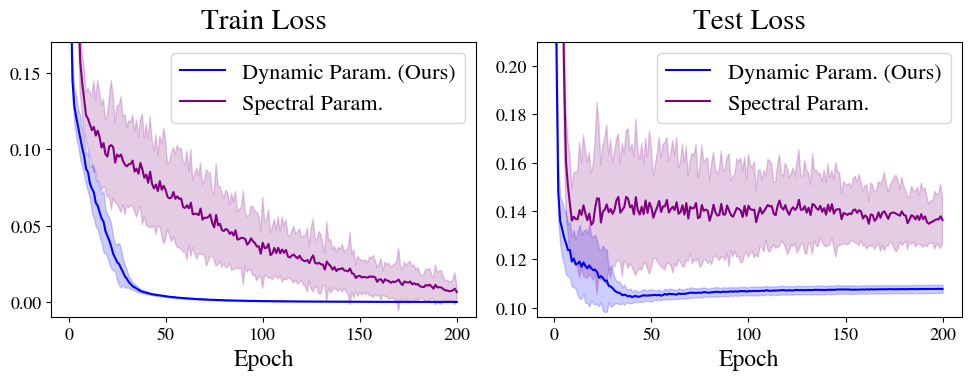